# Daniel Brun - Final Project

## <font color='red'>NOTE - PLEASE READ CAREFULLY BEFORE RUNNING THIS PROJECT</font>

## You might need to have <font color ='lightgreen'>NVIDIA GPU's with CUDA cores</font> integrated to use Numba

### This project uses NVIDIA GPU cores as well as multiple matrices. It is needed to have enough ram (recommended 16GB) to run the whole project. Some packages might not work if you do not have compatible GPU or enough power processing.

## If you downloaded the files type <font color = 'purple'>user = 1</font> in the next cell. Make sure you place the code in the main folder along the folders that are named <font color = 'blue'>"Experiment 09_10...."</font> and similar

In [1]:
# Type 1 if you downloaded the files. Zero only works for code creator

user = 0                                        # 0 only for developer
numba_or_imagej_image = 1                       # Numba 1, ImageJ 0
CPU_or_GPU = 'GPU'                              # Using NVIDIA GPU? Answer with 'CPU' if you don't or 'GPU'
clean_ram_when_done = 0                         # Erase RAW images imported when done processing images? 0 no, 1 yes

In [2]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import imagej
import numba as nb
from numba import cuda, jit, njit, float32, vectorize, uint32, f8, uint8, float64
import glob
import os
import time
from timeit import default_timer as timer
from PIL import Image
import sys
import time
import timeit
defTime = lambda: timeit.default_timer()
import cv2
import math
import gc

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Check if you have NVDIA GPU's with CUDA cores available
cuda.detect()

# Initialize imagej

if numba_or_imagej_image == 0:
    ij = imagej.init()
    print('ImageJ Initialized')

Found 1 CUDA devices
id 0     b'GeForce RTX 3070'                              [SUPPORTED]
                      compute capability: 8.6
                           pci device id: 0
                              pci bus id: 1
Summary:
	1/1 devices are supported


In [5]:
# Define file location and list images

if user == 0:
    download_data_place = r'F:\Research Files\NASA Drone Rover\Schlieren Data'
elif user == 1:
    dowload_data_place = os.getcwd()
    
main_folders = sorted(glob.glob(download_data_place+'\*'))
background_folders = [[[]] * 3]

i = 0
for x in main_folders:
    loc_main = sorted(glob.glob(main_folders[i]+'\*'))
    j = 0
    for y in loc_main:
        if i == 0:
            exp_list_2 = [None] * len(loc_main)
            exp_2 = loc_main
            exp_backg_2 = [None] * len(loc_main)
            k = 0

            for z in exp_2:
                exp_list_2[k] = sorted(glob.glob(exp_2[k]+'\*.tif'))
                k += 1

        elif i == 1:
            exp_list_1 = [None] * len(loc_main)
            exp_1 = loc_main
            k = 0
            
            for z in exp_1:
                exp_list_1[k] = sorted(glob.glob(exp_1[k]+'\*.jpg'))
                k += 1

        elif i == 2:
            exp_list_3 = [None] * len(loc_main)
            exp_3 = loc_main
            exp_backg_3 = [None] * len(loc_main)
            k = 0

            for z in exp_3:
                exp_list_3[k] = sorted(glob.glob(exp_3[k]+'\*.tif'))
                k += 1

        elif i == 3:
            exp_list_4 = [None] * len(loc_main)
            exp_4 = loc_main
            exp_backg_4 = [None] * len(loc_main)
            k = 0

            for z in exp_4:
                exp_list_4[k] = sorted(glob.glob(exp_4[k]+'\*.tif'))
                k += 1
    i += 1

    
exp1 = sorted(exp_list_1)

exp2 = [exp_list_2[0],exp_list_2[2],exp_list_2[3],
        exp_list_2[4],exp_list_2[7],exp_list_2[8],
        exp_list_2[5],exp_list_2[9],exp_list_2[11]]

exp3 = [exp_list_3[1],exp_list_3[2]]
exp4 = [exp_list_4[1],exp_list_4[3],exp_list_4[5],exp_list_4[6],exp_list_4[8]]


exp2_bg = [exp_list_2[1],exp_list_2[1],exp_list_2[1],
           exp_list_2[1],exp_list_2[1],exp_list_2[1],
           exp_list_2[6],exp_list_2[10],exp_list_2[10]]

exp3_bg = [exp_list_3[0],exp_list_3[0]]
exp4_bg = [exp_list_4[0],exp_list_4[2],exp_list_4[4],exp_list_4[7],exp_list_4[7]]
    
whole_list = [exp1,exp2,exp3,exp4]
bg_list = [exp2_bg,exp3_bg,exp4_bg]

x = len(whole_list)
y = [len(exp1),len(exp2),len(exp3),len(exp4)]

conv_files_pil = [[[]]for i in range(x)]
conv_files = [[[]]for i in range(x)]
conv_files_bg = [[[]]for i in range(x)]

i = 0
ii = 0

for xx in range(x):
    conv_files[ii] = [[] for i in range(y[i])]
    i += 1
    ii += 1
    
i = 0
ii = 0

for xx in range(x):
    conv_files_pil[ii] = [[] for i in range(y[i])]
    i += 1
    ii += 1

    
x = len(bg_list)
y = [len(exp2_bg),len(exp3_bg),len(exp4_bg)]

i = 0
ii = 0

for xx in range(x):
    conv_files_bg[ii] = [[]for i in range(y[i])]
    i += 1
    ii += 1

In [6]:
# Import Background

def import_images_numba_pil_bg(i,j,z):
    
    img = Image.open(z).convert('L')
    np_img = np.array(img)
    np_img = np.array(np_img, dtype = 'uint8')
    conv_files_bg[i][j].append(np_img)

i = 0

for x in bg_list:
    j = 0
    for y in x:
        k = 0
        while k <= 4:
            z = y[k]
            import_images_numba_pil_bg(i,j,z)
            k += 1
        j += 1
    i += 1

# Using ImageJ to Load and Process Images

In [7]:
# Use ImageJ to process images
def image_j_process(i,j,z):
    image_op = ij.io().open(z)
    conv_files[i][j].append(ij.py.from_java(image_op))
    

# Using Numba CUDA to Load and Process Images

# Using PIL to Load Images

In [8]:
# Use PIL for import images
def import_images_numba_pil(i,j,z):
    img = Image.open(z).convert('L')
    np_img = np.array(img)
    np_img = np.array(np_img, dtype = 'uint8')
    conv_files_pil[i][j].append(np_img)

In [9]:

# Extraction process function
def extraction_process():
    start = timer()
    i = 0
    for x in whole_list:
        j = 0
        for y in x:
            startTime = defTime()
            drawTimes = []
            totalFiles = float(len(y))
            
            k = 0
            #for z in y:
            while k <= 100:
                drawStartTime = defTime()
                
                z = y[k]
                if numba_or_imagej_image == 0:
                    image_j_process(i,j,z)
                    k += 1

                elif numba_or_imagej_image == 1:
                    import_images_numba_pil(i,j,z)
                    k += 1
                    
                if i == 0:
                    format_img = 'jpeg '
                elif i > 0:
                    format_img = 'tif '
                    
                drawEndTime = defTime()
                drawTime = drawEndTime - drawStartTime
                drawTimes.append(drawTime)
                elapsedTime = defTime() - startTime
                totalTime = totalFiles * np.mean(drawTimes)
                remainingTime = totalFiles * np.mean(drawTimes) - elapsedTime
                drawTimes.append(drawTime)
                
                print('Working with: Experiment %0.0f Case %0.0f | Image: %0.0f | Time per frame: %0.3fs | Remaining Time: %0.3fs | Total Time: %0.3fs                          '%(i+1, j+1, k+1, drawTime, remainingTime, totalTime), end = '\r')

            j += 1
        i += 1

    dt = timer() - start
    
    print('Total time of processing: %0.1f seconds                                                                                                                                '%dt)

In [10]:
@cuda.jit
def multiply_stride(a, b, c): 
    s1, s2 = cuda.grid(2)
    d1, d2 = cuda.gridsize(2)
    for i1 in range(s1, a.shape[0], d1): 
        for i2 in range(s2, b.shape[1], d2): 
            the_sum = 0
            for k in range(b.shape[0]): # or a.shape[1] 
                the_sum += a[i1][k]*b[k][i2]
            c[i1, i2] = the_sum

In [11]:
@cuda.jit
def subtract_background(a, b, c): 
    s1, s2 = cuda.grid(2)
    d1, d2 = cuda.gridsize(2)
    for i1 in range(s1, a.shape[0], d1): 
        for i2 in range(s2, b.shape[0], d2): 
            the_sum = a[i1][i2] / b[i1][i2]
            c[i1, i2] = the_sum

In [12]:
@cuda.jit
def subtract_background_2(a, b, c): 
    s1, s2 = cuda.grid(2)
    d1, d2 = cuda.gridsize(2)
    c[:,:] = a - b

In [13]:
def use_gpu_process():
    global mult_files
    timetot = 0
    whole_start = timer()
    mult_files = []
    data_size = conv_files_pil[1][0][0]
    threadsperblock = (32,32)
    blockspergrid_x = math.ceil(data_size.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(data_size.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    total_files = 0
    
    
    for i in range(1,3):
        xxx = conv_files_pil[i]
        
        j = 0
        i_bg = i-1
        for xx in xxx:
            jj = 0
            y = conv_files_bg[i_bg][j][0]
            for x in xx:
                
                a = x
                b = y
                d_a = cuda.to_device(a)
                d_b = cuda.to_device(b)
                c = np.zeros((a.shape[0], b.shape[1]))
                d_c = cuda.to_device(c)
                start = timer()
                subtract_background[blockspergrid,threadsperblock](d_a, d_b, d_c)
                #multiply_stride[blockspergrid,threadsperblock](d_a, d_b, d_c)
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Background Substraction'%(i,j,jj), end = '\r')
                dt = timer() - start
                timetot = timetot + dt
                pp_c = d_c.copy_to_host()
                pp_c = np.array(pp_c, dtype = 'float32')
                mult_files.append(pp_c)
                total_files += 1
                jj += 1
            j +=1
            
    totalTime_of_process = timer() - whole_start
    print('                                                                                                                                                            ')
    print('Using NVIDIA RTX 3070 GPU (@1725MHz): \n\u2022 Images Processed %0.0f \n\u2022 Image Processing Time: %0.5f \n\u2022 Total Process Time: %0.5f seconds'%(total_files, timetot, totalTime_of_process))
    test_1 = d_c.copy_to_host()
    plt.imshow(test_1, cmap = 'gray')

In [14]:
def use_cpu_process():
    global mult_files_cpu
    timetot = 0
    whole_start = timer()
    mult_files_cpu = []
    total_files = 0
    
    for i in range(1,3):
        xxx = conv_files_pil[i]

        j = 0
        i_bg = i-1
        for xx in xxx:
            jj = 0
            y = conv_files_bg[i_bg][j][0]
            for x in xx:
                
                b = y
                a = x
                c = np.zeros((a.shape[0], b.shape[1]))
                start = timer()
                for i1 in range(a.shape[0]): 
                    for i2 in range(a.shape[1]): 
                        the_sum = a[i1][i2] / b[i1][i2]
                        c[i1][i2] = the_sum
                pp_c = np.array(c, dtype = 'float32')
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Background Substraction'%(i,j,jj), end = '\r')
                dt = timer() - start
                timetot = timetot + dt
                mult_files_cpu.append(pp_c)
                total_files += 1
                jj += 1
                
            j += 1
    totalTime_of_process = timer() - whole_start
    print('                                                                                                                                                            ')
    print('Using i9-9900K (@5.0GHz): \n\u2022 Images Processed %0.0f \n\u2022 Image Processing Time: %0.5f \n\u2022 Total Process Time: %0.5f seconds'%(total_files, timetot, totalTime_of_process))
    test_1 = c
    plt.imshow(test_1, cmap = 'gray')

In [15]:
# Benchmark
extraction_process()

Total time of processing: 8.8 seconds                                                                                                                                


                                                                                                                                                            
Using NVIDIA RTX 3070 GPU (@1725MHz): 
• Images Processed 1111 
• Image Processing Time: 0.38759 
• Total Process Time: 8.74459 seconds


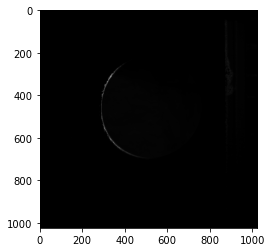

In [16]:
if CPU_or_GPU == 'GPU':
    use_gpu_process()

In [17]:
if CPU_or_GPU == 'CPU':
    use_cpu_process()

In [18]:
def use_cpu_process_complete_division():
    global mult_files_cpu
    timetot = 0
    whole_start = timer()
    mult_files_cpu = []
    total_files = 0
    
    for i in range(1,3):
        xxx = conv_files_pil[i]

        j = 0
        i_bg = i-1
        for xx in xxx:
            jj = 0
            y = conv_files_bg[i_bg][j][0]
            for x in xx:
                
                b = y
                a = x
                c = np.zeros((a.shape[0], b.shape[1]))
                start = timer()
                the_sum = a / b
                c = the_sum
                pp_c = np.array(c, dtype = 'float32')
                print('Experiment %0.0f | Case %0.0f | Frame % 0.0f | Background Substraction'%(i,j,jj), end = '\r')
                dt = timer() - start
                timetot = timetot + dt
                mult_files_cpu.append(pp_c)
                total_files += 1
                jj += 1
                
            j += 1
    totalTime_of_process = timer() - whole_start
    print('                                                                                                                                                            ')
    print('Using i9-9900K (@5.0GHz): \n\u2022 Images Processed %0.0f \n\u2022 Image Processing Time: %0.5f \n\u2022 Total Process Time: %0.5f seconds'%(total_files, timetot, totalTime_of_process))
    test_1 = c
    plt.imshow(test_1, cmap = 'gray')

                                                                                                                                                            
Using i9-9900K (@5.0GHz): 
• Images Processed 1111 
• Image Processing Time: 3.99369 
• Total Process Time: 4.03304 seconds


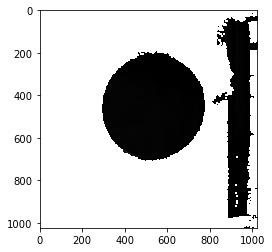

In [19]:
use_cpu_process_complete_division()

In [20]:
# Clean Cache from imported files for RAM
if clean_ram_when_done == 1:
    del conv_files_bg
    del conv_files_pil
    gc.collect()

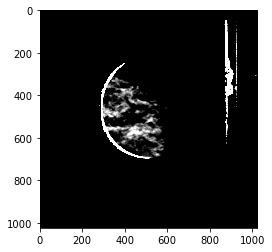

In [21]:
%matplotlib inline

from IPython.display import clear_output
from time import sleep

for a in mult_files:
    plt.imshow(a, cmap = 'gray', vmin = 0.8, vmax = 1)
    plt.show()
    #sleep(1/100)
    clear_output(wait=True)

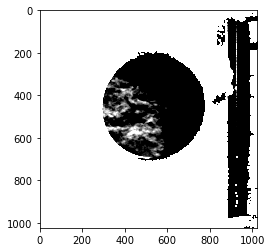

In [22]:
%matplotlib inline

from IPython.display import clear_output
from time import sleep

for a in mult_files_cpu:
    plt.imshow(a, cmap = 'gray', vmin = 0.8, vmax = 1)
    plt.show()
    #sleep(1/100)
    clear_output(wait=True)